In [1]:
import json
import numpy as np
import pandas as pd

import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


import preprocessor as p # 
import string # use string.punctuation to clean out punctuation

from pprint import pprint

from datetime import datetime
import pickle



from tqdm import tqdm

pd.set_option('display.max_colwidth', -1)

In [2]:
with open("clean_tweets_sample.pkl", 'rb') as picklefile: 
    sampleDF = pickle.load(picklefile)

In [3]:
with open("clean_tweets_full.pkl", 'rb') as picklefile: 
    fullDF = pickle.load(picklefile)

## Preprocessing

In [4]:
def just_text(tweetsDF):
    cleanDF = pd.DataFrame(columns = ['id','full_text'])
    cleanDF['full_text'] = tweetsDF['full_text']
    cleanDF.drop('id',axis = 1).head()
    return cleanDF

In [5]:
sampletextDF = just_text(sampleDF)

In [6]:
fulltextDF = just_text(fullDF)

# Set Stopwords

In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop += ['climate', 'change', 'global', 'warming', 'climatechange', 'globalwarming']

## Count Vectorizer

In [8]:
def run_countvec(tweetDF):

    # Create a CountVectorizer for parsing/counting words
    count_vectorizer = CountVectorizer(ngram_range=(1, 2), #max_df = 0.8,  
                                   stop_words=stop, token_pattern="\\b[a-z][a-z]+\\b")
    count_vectorizer.fit(tweetDF.full_text)
    
    # Create the term-document matrix
    # Transpose it so the terms are the rows
    counts = count_vectorizer.transform(tweetDF.full_text).transpose()
    return count_vectorizer, counts

In [83]:
sample_count_vectorizer, sample_counts = run_countvec(sampletextDF)

In [9]:
full_count_vectorizer, full_counts = run_countvec(fulltextDF)

In [13]:
len(full_count_vectorizer.vocabulary_)

73998

## TF-IDF

In [12]:
def run_tfidf(counts):
    transformer = TfidfTransformer(smooth_idf=False)
    x_tfidf = transformer.fit_transform(sample_counts)
    #xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)
    return x_tfidf

In [13]:
sample_tfidf = run_tfidf(sample_counts)

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1067: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0


In [11]:
sample_counts.shape

(51177, 17579)

In [33]:
full_tfidf = run_tfidf(full_counts)

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1067: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0


In [61]:
full_counts.shape

(73998, 180920)

## NMF with tf-idf

In [37]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer

def run_nmf(num_topics, word_agg):
    nmf_model = NMF(num_topics)

    nmf = nmf_model.fit_transform(word_agg)
    nmf = Normalizer(copy=False).fit_transform(nmf)
    return nmf_model

In [62]:
sample_nmf_model = run_nmf(3, sample_tfidf)

In [63]:
full_nmf_model = run_nmf(3, full_tfidf)

In [64]:
def get_nmf_topics(model, n_top_words, count_vectorizer):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [65]:
get_nmf_topics(sample_nmf_model, 10,sample_count_vectorizer)

,Topic # 01,Topic # 02,Topic # 03
0,bizarre,children tm,crop failures
1,bj rn,climatescambs,continue plan
2,controversial right,da,confused
3,controls weather,cannot read,crossing
4,controversial geoengineering,conversation,coverage
5,energy engine,control vomiting,could tide
6,far discussion,controls biomass,continue lost
7,check report,controls,could words
8,florida doctors,could rising,concept better
9,equates,could reduce,crossed parisagreement


In [66]:
get_nmf_topics(full_nmf_model, 10,full_count_vectorizer)

,Topic # 01,Topic # 02,Topic # 03
0,blows,author brings,check elainer
1,brits,causes decided,chief doubts
2,christ way,causes effects,checkmates science
3,behind dont,causes enhanced,changed back
4,causes might,australian vineyards,checkmate
5,causes,cousteau,changed confusion
6,causes death,degree higher,cause extinction
7,causes crop,blitz engineers,called yet
8,chance one,diabetes,chart family
9,chance live,crude oil,cause got


In [67]:
def get_nmf_topics_freq(topic, model, n_top_words, count_vectorizer):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = count_vectorizer.get_feature_names()
    
    word_dict = {};
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
    freq = sorted(model.components_[topic])[:-n_top_words - 1: -1]
    
    words_ids = model.components_[topic].argsort()[:-n_top_words - 1:-1]
    words = [feat_names[key] for key in words_ids]
    
    for i in range(n_top_words):
        word_dict[words[i]] = freq[i]

    
    return word_dict

In [69]:
get_nmf_topics_freq(0,sample_nmf_model, 10, full_count_vectorizer)

{'australian vineyards': 1.0223323393610275,
 'author brings': 1.0223323393610275,
 'blitz engineers': 0.08654902418117687,
 'causes decided': 1.0223323393610275,
 'causes effects': 1.0223323393610275,
 'causes enhanced': 1.0223323393610275,
 'cousteau': 0.9594936795516206,
 'crude oil': 0.06824007885768676,
 'degree higher': 0.9014020497441854,
 'diabetes': 0.07986612718529185}

In [70]:
np.argsort([3,0,1])[::-1]
sorted([3,0,1])[::-1]
([3,0,1]).sort()

In [71]:
sample_nmf_model.components_

array([[1.38330356e-04, 3.87776853e-04, 1.02485499e-03, ...,
        4.84371305e-04, 2.83144603e-04, 9.47130870e-05],
       [7.04400704e-05, 3.16394403e-04, 2.82017721e-04, ...,
        1.15214157e-04, 7.30116924e-05, 6.98980432e-05],
       [1.59577532e-04, 6.47696489e-04, 1.02557263e-02, ...,
        5.22115169e-04, 5.40363099e-04, 5.60635032e-03]])

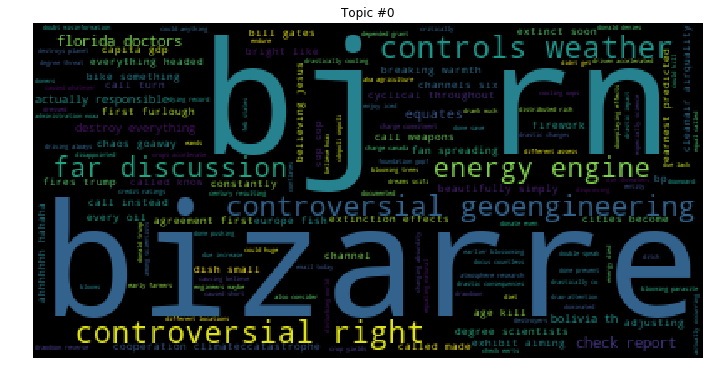

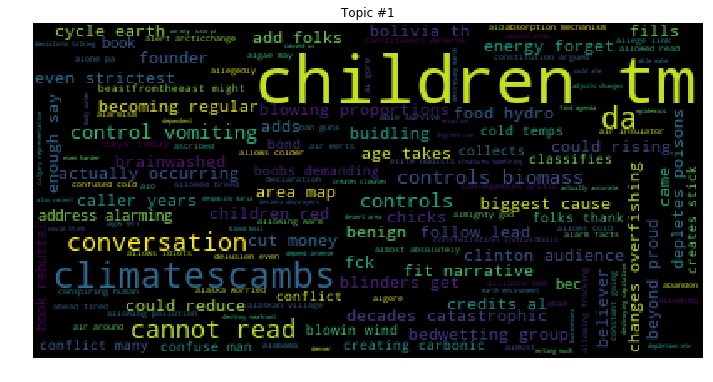

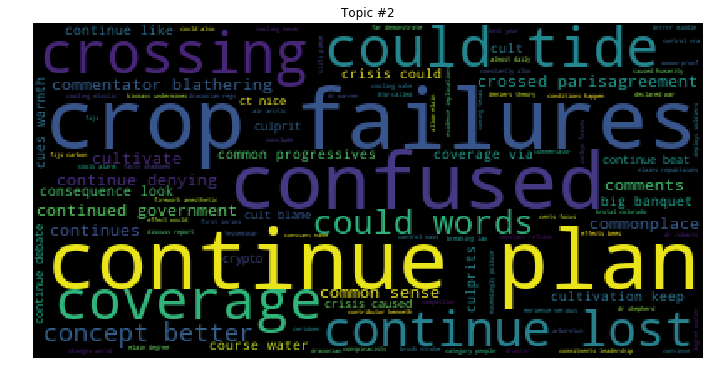

In [72]:
for t in range(num_topics):
    plt.figure(figsize = (12,16))
    plt.imshow(WordCloud().fit_words(dict(get_nmf_topics_freq(t, sample_nmf_model,200,sample_count_vectorizer))))
    plt.axis('off')
    plt.title('Topic #' + str(t))
    plt.show();

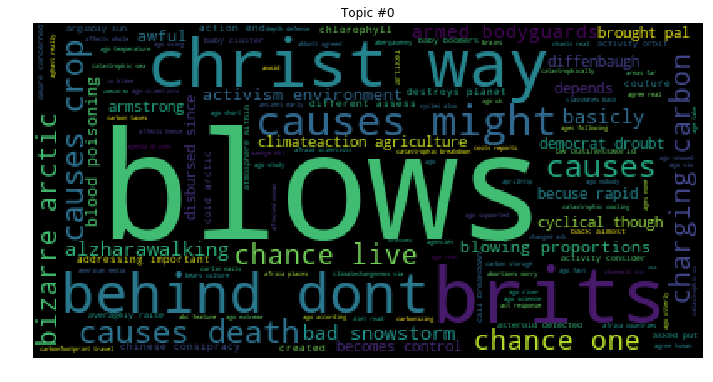

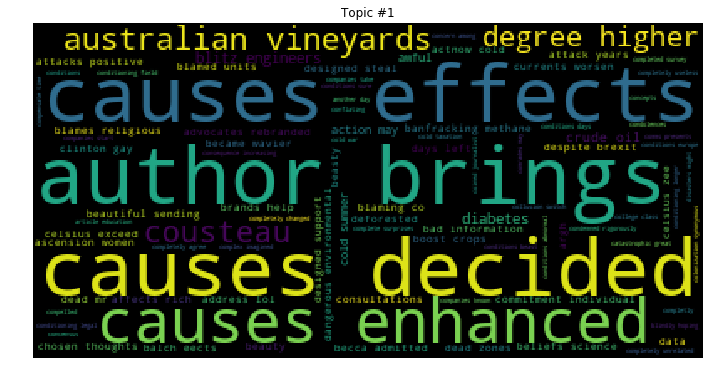

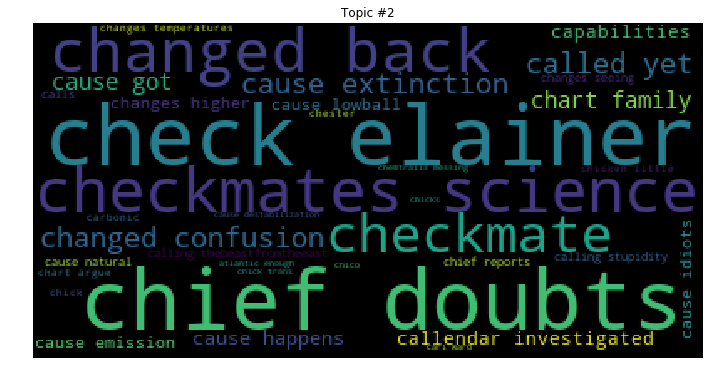

In [73]:
for t in range(num_topics):
    plt.figure(figsize = (12,16))
    plt.imshow(WordCloud().fit_words(dict(get_nmf_topics_freq(t, full_nmf_model,200,full_count_vectorizer))))
    plt.axis('off')
    plt.title('Topic #' + str(t))
    plt.show();

## NMF with Count Vectorizer

In [85]:
sample_nmf_model = run_nmf(3, sample_counts)

In [86]:
full_nmf_model = run_nmf(3, full_counts)

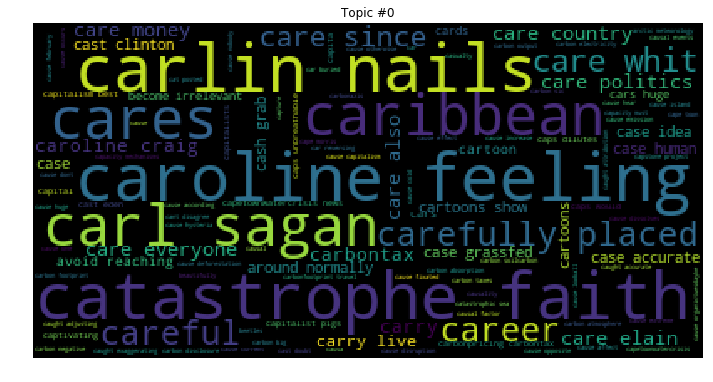

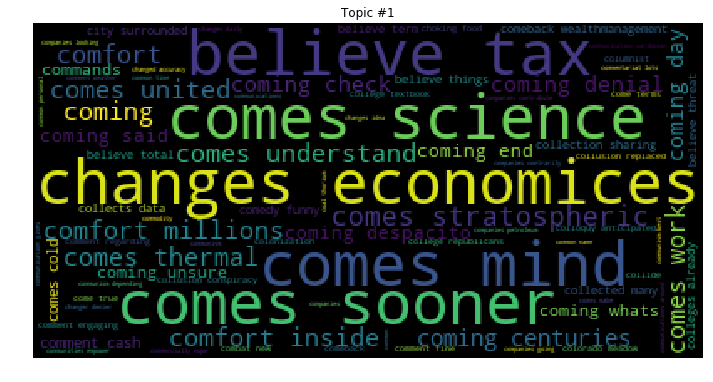

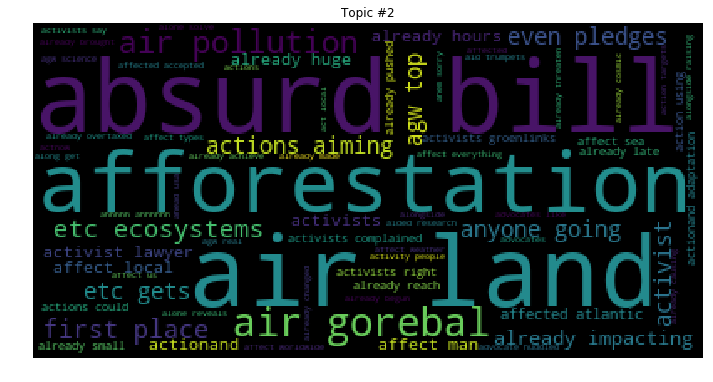

In [87]:
for t in range(num_topics):
    plt.figure(figsize = (12,16))
    plt.imshow(WordCloud().fit_words(dict(get_nmf_topics_freq(t, sample_nmf_model,200, sample_count_vectorizer))))
    plt.axis('off')
    plt.title('Topic #' + str(t))
    plt.show();

In [88]:
for t in range(num_topics):
    plt.figure(figsize = (12,16))
    plt.imshow(WordCloud().fit_words(dict(get_nmf_topics_freq(t, full_nmf_model,200, full_count_vectorizer))))
    plt.axis('off')
    plt.title('Topic #' + str(t))
    plt.show();

IndexError: list index out of range

In [80]:
feat_names = full_count_vectorizer.get_feature_names()
words_ids = full_nmf_model.components_[2].argsort()[:-200 - 1:-1]
[feat_names[key] for key in words_ids]

IndexError: list index out of range

In [81]:
full_count_vectorizer.get_feature_names()

['aa',
 'aa skte',
 'aaaaiwao',
 'aaasmtg',
 'aaenge',
 'aaenge nhi',
 'aanjager',
 'aanjager van',
 'aap',
 'aap aa',
 'aarde',
 'aarde heeft',
 'aarde zorgt',
 'ab',
 'ab act',
 'ab conservatives',
 'ab need',
 'ab unless',
 'abandon',
 'abandon ice',
 'abandon scientific',
 'abandoned',
 'abandoned skypapers',
 'abandoned struggle',
 'abandoned terms',
 'abandoning',
 'abandoning faith',
 'abate',
 'abate saviour',
 'abated',
 'abated usefully',
 'abatement',
 'abatement fund',
 'abbott',
 'abbott agreed',
 'abbott gets',
 'abbott reassure',
 'abc',
 'abc cbs',
 'abc feature',
 'abc news',
 'abc online',
 'abc reports',
 'abc seriously',
 'abcnews',
 'abeg',
 'abergavenny',
 'abergavenny warned',
 'aberrant',
 'aberrant behavior',
 'aberrations',
 'aberrations recently',
 'abetals',
 'abetals basin',
 'abiding',
 'abiding citizens',
 'abilities',
 'ability',
 'ability absorb',
 'ability adapt',
 'ability buy',
 'ability report',
 'ability suck',
 'ablaze',
 'ablaze known',
 'able',
